# Exercise: Surface Diffusion via Kinetic Monte Carlo

In this notebook, we explore surface diffusion phenomena using a lattice gas model on a 2D honeycomb lattice, solved via Kinetic Monte Carlo (KMC). This approach allows us to model how adsorbed atoms (adsorbates) migrate across a surface over time by hopping between discrete lattice sites.


### What is the lattice gas model?

The lattice gas model simplifies surface diffusion by representing the surface as a regular grid (lattice) of discrete sites. Each site can either be occupied (by an adsorbate) or vacant, and particles hop between neighboring sites.

In our framework, these hops are governed by probabilistic rules derived from a simplified energy model:

* We do not compute atomistic energy barriers from first principles.
* Instead, we assign fixed interaction energies (e.g., for neighboring particles or site preferences), and use these to compute relative jump probabilities.
* These probabilities follow a Metropolis-like rule:

  $$
  P_{\text{jump}} \propto 
  \begin{cases}
  \exp\left(-\frac{\Delta E}{kT}\right) & \text{if } \Delta E > 0 \\\\
  1 & \text{otherwise}
  \end{cases}
  $$

  where $\Delta E$ is the energy change associated with the hop.


### How is time handled in Kinetic Monte Carlo?

There are two main interpretations of time in KMC simulations, depending on the level of physical input:

#### Atomistic KMC: absolute rates and real time

In atomistic KMC, one often computes jump rates from barriers (e.g., using transition state theory):

$$
\Gamma = \nu \cdot e^{-E_a / kT}
$$

These rates have units of 1/s, so the algorithm accumulates a physically meaningful time via:

$$
\Delta t = \frac{1}{\sum_i \Gamma_i}
$$

In this case, KMC simulates actual time evolution.

#### Lattice MC (**like in this notebook**): relative rates and dimensionless time

* In lattice-based models, we often want to explore generic behavior without specifying exact chemistry.
* The simulations in this notebook are performed using a *rejection-free kinetic Monte Carlo (KMC) scheme*. This means:
    * All possible particle hops are assigned a relative rate, which may depend on local site occupancy or interaction energies.
    * A hop is chosen with probability proportional to its rate.
    * The simulation clock is advanced using:

  $$
  \Delta t = \frac{1}{\sum_i r_i}
  $$

In our notebook, we typically use unitless rates, so the simulated time remains dimensionless, but still faithfully tracks the relative pace of diffusion under different assumptions.

> **Note**: This approach is designed for efficiency and pedagogical clarity. We do not aim to perform large-scale simulations with statistically converged transport properties. That would require much longer runs and careful parameterization of the potential energy landscape, which is absolutely possible, just not the goal here.

<div style="text-align: center;">
    <img src="https://www.frontiersin.org/files/Articles/434159/fchem-07-00202-HTML/image_m/fchem-07-00202-g002.jpg", width=600>
</div>

In [1]:
#!pip install lattice_mc

import lattice_mc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from math import fabs
import copy

sns.set_context("talk")

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# === Global variables ===
kT = lattice_mc.global_vars.kT  # default T = 298 K

# Task (a) Non-interacting particles

The key assumption in this task is that particles are non-interacting: they do not feel any energetic attraction or repulsion from other particles. 

However, volume exclusion is enforced: a particle cannot hop into an already occupied site.

We simulate atomic diffusion on a honeycomb lattice with $48$ sites.

Modify the following variables to control the simulation:

- `n_steps`:
Number of MC steps.
Set to $10000$ to allow atoms enough time to explore the lattice.

- `n_samples`:
Number of repeated simulations for each atom count.
Set to $100$ to get statistically meaningful averages.

- `n_atoms_list`:
A list of atom counts you want to simulate.
Use $1, 2, 4$.

Run the simulations and execute the cell that plots the mean squared displacement as a function of time.

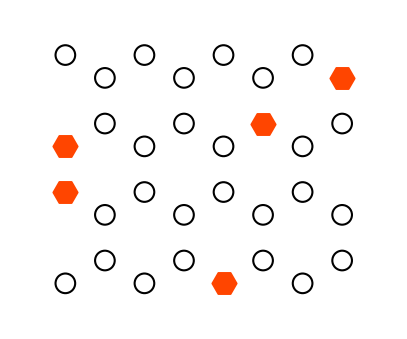

In [3]:
# JUST A FIGURE
np.random.seed(23)
lattice = lattice_mc.init_lattice.honeycomb_lattice(4, 2, 1)
lattice.populate_sites(5)

def plot_lattice(lattice, ax=None):
    # Extract positions
    occupied_positions = np.array([site.r[:2] for site in lattice.occupied_sites()])
    vacant_positions = np.array([site.r[:2] for site in lattice.vacant_sites()])

    # Use provided Axes or create new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.scatter(*vacant_positions.T, s=200, facecolors='none', edgecolors='black')
    ax.scatter(*occupied_positions.T, marker="H", s=300, color='orangered')

    ax.set_aspect('equal')
    ax.axis('off')
    ax.margins(0.2)

    return ax  # Optionally return ax if needed

fig = plot_lattice(lattice)

In [ ]:
# COMPLETE AND EXECUTE THIS CELL
# Parameters
n_steps = 10000
n_samples = 100
n_atoms_list = [1, 2, 4]

# === MSD computation ===
def run_msd_ensemble(n_atoms, nsamples=25, n_time_points=200):
    """
    Run an ensemble of MSD (mean squared displacement) simulations for a given number of atoms.

    Returns a DataFrame with columns: ['sample', 'time', 'msd', 'n_atoms'].
    """
    a, b = 4, 3
    spacing = 1.0

    results = []
    for _ in tqdm(range(nsamples), desc=f"{n_atoms} atoms"):
        s = lattice_mc.Simulation()
        s.lattice = lattice_mc.init_lattice.honeycomb_lattice(a, b, spacing)
        s.set_number_of_atoms(n_atoms)
        s.set_number_of_jumps(n_steps)

        times = []
        msd = []

        s.lattice.reset()
        for _ in range(n_steps):
            s.lattice.jump()
            times.append(s.lattice.time)
            msd.append(s.atoms.sum_dr_squared() / n_atoms)

        results.append((np.array(times), np.array(msd)))

    # Interpolate to common time base
    min_t_max = min(times[-1] for times, _ in results)
    t_common = np.linspace(0, min_t_max, n_time_points)

    records = []
    for sample_id, (times, msd) in enumerate(results):
        f_interp = interp1d(times, msd, kind='linear', bounds_error=False, fill_value='extrapolate')
        msd_interp = f_interp(t_common)
        for t, v in zip(t_common, msd_interp):
            records.append({"sample": sample_id, "time": t, "msd": v, "n_atoms": n_atoms})

    return pd.DataFrame(records)

df_all = pd.concat([run_msd_ensemble(n_atoms=n, nsamples=n_samples) for n in n_atoms_list], ignore_index=True)

1 atoms:   0%|          | 0/100 [00:00<?, ?it/s]

2 atoms:   0%|          | 0/100 [00:00<?, ?it/s]

4 atoms:   0%|          | 0/100 [00:00<?, ?it/s]

,sample,time,msd,n_atoms
0,0,0.000000e+00,-39.992155,1
1,0,1.616280e-12,5.396166,1
2,0,3.232560e-12,1.722203,1
3,0,4.848840e-12,30.952045,1
4,0,6.465121e-12,10.285722,1
...,...,...,...,...
59995,99,8.488406e-11,2447.081975,4
59996,99,8.531936e-11,2433.210901,4
59997,99,8.575466e-11,2674.504638,4
59998,99,8.618996e-11,2578.496229,4


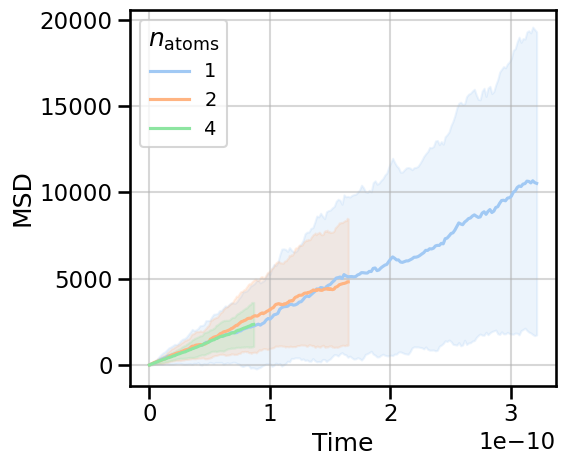

In [5]:
# EXECUTE THIS CELL
plt.figure(figsize=(6, 5))

sns.lineplot(data=df_all, x="time", y="msd", hue="n_atoms", errorbar="sd", palette="pastel")

plt.xlabel("Time")
plt.ylabel("MSD")

#plt.xscale("log")
plt.grid(alpha=0.5)

plt.legend(title=r"$n_{\text{atoms}}$", fontsize=14)
plt.tight_layout()
plt.show()

Do you notice anything?

When performing kinetic Monte Carlo (kMC) simulations at different coverages (or concentrations), what practical considerations should be made to ensure that the results are comparable across coverages? 

Specifically, does running the same number of kMC events correspond to the same physical time scale at each coverage, or do differences in event rates and dynamics require adjustment?

Discuss.

<details>
<summary>Solution</summary>
In kinetic Monte Carlo simulations, the total number of events does not necessarily translate to the same physical time at different coverages, because:

* The event list grows as a function of the number of diffusing species.
* The event rate can vary significantly with coverage due to changes in available sites and interaction effects.
* The attempt frequency and success rate of moves may be lower at higher coverage, affecting the simulation time increment per event.

Thus, to ensure comparability one should consider normalizing time using cumulative time from the kMC clock (i.e., physical time, not number of events).
</details>

## Task (b) Transport properties as a function of coverage

The lattice has a fixed number of sites ($48$).

You will simulate diffusion of particles for different coverages $\Theta$, defined by the number of particles on the lattice.
This setup allows you to simulate how transport properties vary with the number of particles, even without any inter-particle interaction, just due to crowding and excluded volume effects.


Define a list of particle counts corresponding to different coverages:

* $1$ particle (dilute limit)

* $1$ vacancy

* $25\%$ coverage

* $50\%$ coverage

* $75\%$ coverage

The simulation returns a summary of key quantities: 

- The tracer diffusivity, $D$, 
- The correlation factor, $f$,
- The order parameter $|n_A - n_B| / N$ that quantifies whether particles preferentially occupy one of two different sublattices $A$ and $B$.

Discuss the dependence of these properties on $\Theta$. 

> **What is the correlation factor?**

In a random walk, the mean squared displacement (MSD) is defined as:
$
\text{MSD}_r = \sum \langle x_i^2 \rangle.
$

 If the jumps are correlated (i.e., not random), deviations from ideality are packaged in the *correlation factor*:
$
\text{MSD} = f \cdot \text{MSD}_r.
$

 For a pure random walk, $f = 1$. 

 Although $0<f<1$, you might observe unphysical values due to finite-size effects and poor statistics.

In [2]:
# EXECUTE THIS CELL
def run_correlation_and_order_parameter_simulations(
    n_atoms_list,
    E_nn_list=0.0,
    n_samples=100,
    use_alternating_sites=False,
    compute_order_parameter=False
):
    """
    Generalized function to compute tracer diffusion, correlation, and order parameter.

    Returns a DataFrame with fixed columns: ["n_atoms", "E_nn", "D*", "f", "order_parameter"]
    """
    a, b = 4, 3
    spacing = 1.0
    n_jumps = 10000
    n_equil = 100 #if compute_order_parameter else 0

    if isinstance(E_nn_list, (float, int)):
        E_nn_list = [E_nn_list]

    results = []

    for n_atoms in n_atoms_list:
        print(f"Running simulations for n_atoms = {n_atoms}")
        for E_nn in E_nn_list:
            samples = []
            for _ in tqdm(range(n_samples), desc=f"  E_nn = {E_nn}"):
                s = lattice_mc.Simulation()
                s.lattice = lattice_mc.init_lattice.honeycomb_lattice(
                    a, b, spacing, alternating_sites=use_alternating_sites
                )
                s.set_number_of_atoms(n_atoms)
                s.set_number_of_jumps(n_jumps)
                if compute_order_parameter:
                    s.set_number_of_equilibration_jumps(n_equil)
                s.set_nn_energy(E_nn * kT)
                s.setup_lookup_table()
                s.run()

                D_star = s.tracer_diffusion_coefficient 
                f_corr = s.tracer_correlation
                order_param = (
                    fabs(s.average_site_occupations['A'] - s.average_site_occupations['B']) / 24
                    if compute_order_parameter else np.nan
                )
                samples.append([D_star, f_corr, order_param])

            mean_vals = np.mean(samples, axis=0)
            results.append([n_atoms, E_nn, *mean_vals])

    columns = ["n_atoms", "E_nn", "D*", "f", "order_parameter"]
    return pd.DataFrame(results, columns=columns)

In [3]:
# COMPLETE AND EXECUTE THIS CELL
data_non = run_correlation_and_order_parameter_simulations(
    n_atoms_list=[1, 12, 24, 36, 47],
    E_nn_list=0.0,
    n_samples=100,
    use_alternating_sites=True,
    compute_order_parameter=True
)

Running simulations for n_atoms = 1


  E_nn = 0.0:   0%|          | 0/100 [00:00<?, ?it/s]

Running simulations for n_atoms = 12


  E_nn = 0.0:   0%|          | 0/100 [00:00<?, ?it/s]

Running simulations for n_atoms = 24


  E_nn = 0.0:   0%|          | 0/100 [00:00<?, ?it/s]

Running simulations for n_atoms = 36


  E_nn = 0.0:   0%|          | 0/100 [00:00<?, ?it/s]

Running simulations for n_atoms = 47


  E_nn = 0.0:   0%|          | 0/100 [00:00<?, ?it/s]

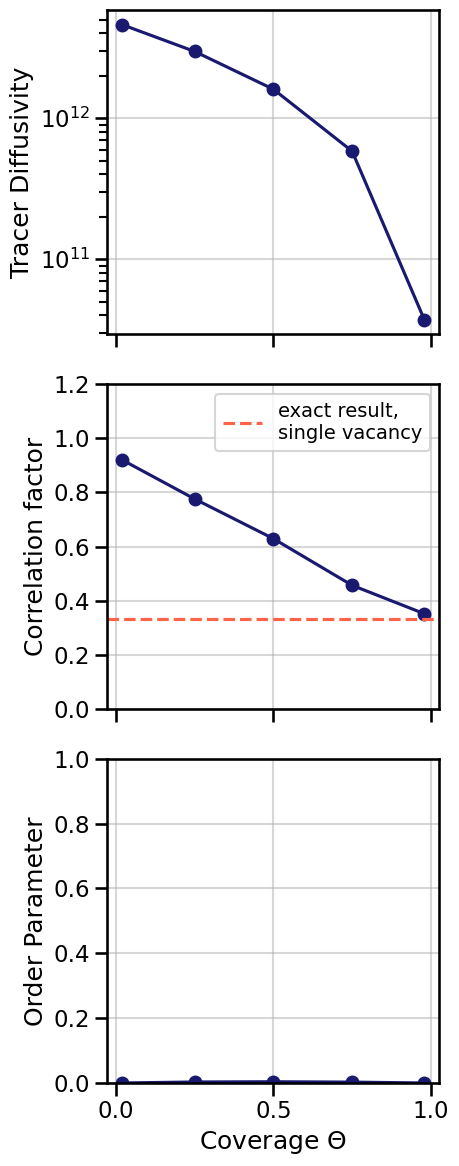

In [4]:
# EXECUTE THIS CELL
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(5, 12))

# Tracer Diffusivity
ax1.plot(data_non['n_atoms'] / 48, data_non['D*'], 'o-', c='midnightblue')
ax1.set_yscale('log')
ax1.grid(alpha=0.5)
ax1.set_ylabel("Tracer Diffusivity")

# Correlation Factor
ax2.plot(data_non['n_atoms'] / 48, data_non['f'], 'o-', c='midnightblue')
ax2.set_ylim(0.0, 1.2)
ax2.axhline(1/3, color='tomato', ls='--', label=f"exact result,\nsingle vacancy")
ax2.grid(alpha=0.5)
ax2.legend(fontsize=14)
ax2.set_ylabel("Correlation factor")

# Order Parameter
ax3.plot(data_non['n_atoms'] / 48, data_non['order_parameter'], 'o-', c='midnightblue')
ax3.set_ylim(0.0, 1)
ax3.grid(alpha=0.5)
ax3.set_xlabel(r"Coverage $\Theta$")
ax3.set_ylabel("Order Parameter")

plt.tight_layout()
plt.show()

# Task (c) Interacting Particles

In the case of non-interacting particles, all allowed jumps are equally probable. However, when interactions are introduced, the probability of each jump becomes dependent on the change in the system's total energy caused by that jump.

In this task, we implement nearest-neighbor repulsion. The total energy of a configuration is calculated by summing over each occupied site $j$, where the contribution of each site depends on the number of its occupied nearest neighbors:

$$
E = \sum_j n_j^{\text{nn}} E_{\text{nn}}
$$

* $n_j^{\text{nn}}$ is the number of occupied nearest-neighbor sites for occupied site $j$.
* $E_{\text{nn}}$ is the interaction energy per neighboring pair (positive for repulsion).


You will perform simulations for different coverages sweeping over various values of the interaction energy $E_{\text{nn}} = 2.0, 3.0, 4.0$.

Set the number of samples to $50$ to speed up the simulations.

Analyze the properties returned by the simulations:

  * The correlation factor,
  * The order parameter $|n_A - n_B| / N$ that quantifies how particles preferentially occupy the two different sublattices $A$ and $B$.

Do you observe any unexpected behavior?
What physical mechanisms might be responsible for this behavior?
Use the provided animation utility to infer the dynamics based on your physical intuition and understanding of the model.

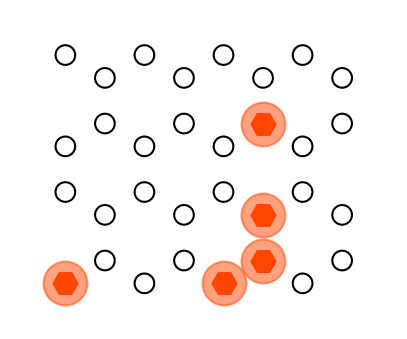

In [9]:
# JUST A FIGURE
np.random.seed(23)
lattice = lattice_mc.init_lattice.honeycomb_lattice(4, 2, 1)
lattice.populate_sites(5)


def plot_lattice(lattice, ax=None):
    # Extract positions
    occupied_positions = np.array([site.r[:2] for site in lattice.occupied_sites()])
    vacant_positions = np.array([site.r[:2] for site in lattice.vacant_sites()])

    # Use provided Axes or create new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.scatter(*vacant_positions.T, s=200, facecolors='none', edgecolors='black')
    ax.scatter(*occupied_positions.T, marker="H", s=300, color='orangered')
    ax.scatter(*occupied_positions.T, s=1000, color='orangered', alpha=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    ax.margins(0.2)

    return ax  # Optionally return ax if needed

fig = plot_lattice(lattice)

In [10]:
# COMPLETE AND EXECUTE THIS CELL
data_nn = run_correlation_and_order_parameter_simulations(
    n_atoms_list=[1, 12, 24, 36, 47],
    E_nn_list=[2.0, 3.0, 4.0],
    n_samples=50,
    use_alternating_sites=True,
    compute_order_parameter=True
)

Running simulations for n_atoms = 1


  E_nn = 2.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 3.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 4.0:   0%|          | 0/50 [00:00<?, ?it/s]

Running simulations for n_atoms = 12


  E_nn = 2.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 3.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 4.0:   0%|          | 0/50 [00:00<?, ?it/s]

Running simulations for n_atoms = 24


  E_nn = 2.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 3.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 4.0:   0%|          | 0/50 [00:00<?, ?it/s]

Running simulations for n_atoms = 36


  E_nn = 2.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 3.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 4.0:   0%|          | 0/50 [00:00<?, ?it/s]

Running simulations for n_atoms = 47


  E_nn = 2.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 3.0:   0%|          | 0/50 [00:00<?, ?it/s]

  E_nn = 4.0:   0%|          | 0/50 [00:00<?, ?it/s]

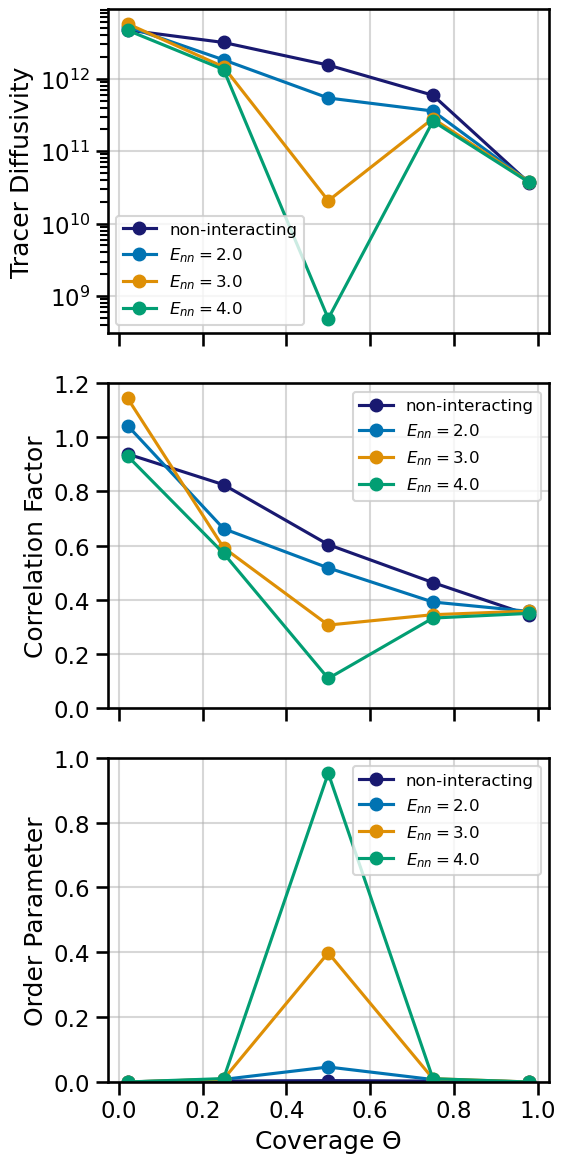

In [13]:
# EXECUTE THIS CELL
E_nn_values = sorted(data_nn["E_nn"].unique())
palette = sns.color_palette("colorblind", n_colors=len(E_nn_values))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6, 12))

# === Tracer Diffusivity ===
ax1.plot(data_non['n_atoms'] / 48, data_non["D*"], 'o-', c='midnightblue', label="non-interacting")
for idx, nn in enumerate(E_nn_values):
    nn_data = data_nn[data_nn.E_nn == nn]
    ax1.plot(nn_data.n_atoms / 48, nn_data["D*"], 'o-', label=rf"$E_{{nn}} = {nn}$", color=palette[idx])
ax1.set_yscale('log')
ax1.set_ylabel("Tracer Diffusivity")
ax1.grid(alpha=0.5)
ax1.legend(fontsize=12)

# === Correlation Factor ===
ax2.plot(data_non['n_atoms'] / 48, data_non['f'], 'o-', c='midnightblue', label="non-interacting")
for idx, nn in enumerate(E_nn_values):
    nn_data = data_nn[data_nn.E_nn == nn]
    ax2.plot(nn_data.n_atoms / 48, nn_data.f, 'o-', label=rf"$E_{{nn}} = {nn}$", color=palette[idx])
ax2.set_ylim(0.0, 1.2)
ax2.set_ylabel("Correlation Factor")
ax2.grid(alpha=0.5)
ax2.legend(fontsize=12)

# === Order Parameter ===
ax3.plot(data_non['n_atoms'] / 48, data_non['order_parameter'], 'o-', c='midnightblue', label="non-interacting")
for idx, nn in enumerate(E_nn_values):
    nn_data = data_nn[data_nn.E_nn == nn]
    ax3.plot(nn_data.n_atoms / 48, nn_data.order_parameter, 'o-', label=rf"$E_{{nn}} = {nn}$", color=palette[idx])
ax3.set_ylim(0.0, 1)
ax3.set_ylabel("Order Parameter")
ax3.set_xlabel(r"Coverage $\Theta$")
ax3.grid(alpha=0.5)
ax3.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# EXECUTE THIS CELL
# === Animation Utility ===
def run_simulation_with_snapshots(lattice, n_atoms, n_steps, interval=1, properties=['lattice']):
    """
    Run lattice MC simulation and return selected snapshots.

    Parameters:
    ----------
    lattice : Lattice
        Honeycomb lattice object.
    n_atoms : int
        Number of atoms to simulate.
    n_steps : int
        Number of lattice jumps.
    interval : int
        Snapshot collection interval.
    properties : list of str
        Properties to collect (default: ['lattice']).

    Returns:
    -------
    list of dict
        First and last snapshots of the simulation.
    """
    s = lattice_mc.Simulation()
    s.lattice = lattice
    s.set_number_of_atoms(n_atoms)
    s.set_nn_energy(4.0 * kT)
    s.setup_lookup_table()

    snapshots = []
    for step in range(n_steps):
        s.lattice.jump()
        if step % interval == 0 or step == n_steps - 1:
            snapshots.append({
                **{key: copy.deepcopy(getattr(s, key)) for key in properties},
                "step_number": step + 1
            })

    return snapshots[:10] + snapshots[-20:] if len(snapshots) > 20 else snapshots

def animate_lattice_snapshots(data):
    fig, ax = plt.subplots()

    def plot_frame(frame):
        ax.clear()
        plot_lattice(data[frame]['lattice'], ax=ax)
        ax.set_title(f"Step {data[frame]['step_number']}")
        return ax,

    ani = FuncAnimation(fig, plot_frame, frames=len(data), init_func=lambda: plot_frame(0), interval=500)
    plt.close(fig)
    return HTML(ani.to_jshtml())

# === Setup and Run ===
a, b = 4, 3
spacing = 1.0
lattice = lattice_mc.init_lattice.honeycomb_lattice(a, b, spacing, alternating_sites=True)
data = run_simulation_with_snapshots(lattice, n_atoms=24, n_steps=1000, interval=1)
animate_lattice_snapshots(data)

<details>
<summary>Solution</summary>

As the nearest-neighbor repulsion energy increases, $f$ decreases as the lattice occupancy approaches $50\%$. 

The order parameter plot shows that this is associated with a preference for all the mobile particles to order on one sublattice.

The system tends to form an ordered structure (e.g., a checkerboard pattern on a square lattice).

A particle from the full sublattice may jump into the empty one (a disordering jump), but such a move violates the preferred order, so it's energetically discouraged or quickly "undone".

The particle often jumps right back — this is the reordering jump.

*These back-and-forth motions are highly correlated and don't contribute much to net diffusion $\rightarrow$ tracer motion is inefficient $\rightarrow$ $f$ is low.*

This explains the minimum in $f$ at $\Theta = 0.5$: you get lots of futile, correlated moves that don't advance diffusion.


####  What happens above 50% coverage? The "vacant" sublattice gets filled

Now we are inserting extra particles into the "vacant" sublattice: this disrupts the perfect order.

It opens up new paths: now two particles — one on each sublattice — may participate in a kind of pair exchange.

* Imagine particle A hops from the full sublattice to the vacant one.

* Then particle B (already on the vacant sublattice) jumps into A's just-vacated site.

* This pair of hops (interstitialcy-like motion)breaks the ordering locally, but doesn't violate the global structure too much.

* The resulting particle motion is less correlated, i.e., more diffusive, so $f$ increases again.